In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *
import copy

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim, ylim):
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=8, width=1.5, direction='in')
        ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=8, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(16) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(16) 
        
        return x_ax, y_ax
####################################### Plotting Function

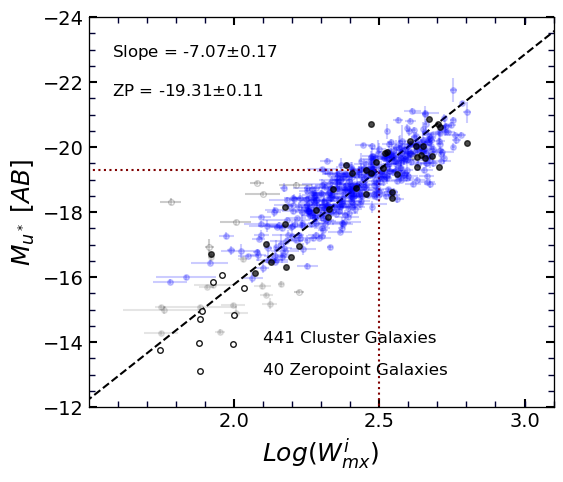

In [3]:
########### Updated list using the color-LogWimx correaltion
calib_maglim = [3974, 6699, 19871, 22277, 28378, 38148, 41020, 41093, 46127, 49448, 53641]
calib_maglim += [6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 44982, 45084, 46127, 67908, 72228]

I_maglim = [38803,   39181,   39431,   39619,   40005,   40107,   40588,   40604,
   41567,   41829,   42768, 5807403, 5057729,   37814]
I_maglim += [38803, 39181, 39431, 40005, 40107, 40147, 41567, 42768, 14548, 14590]

table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

band = 'u'

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                            band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True, 
                                            OP_IR=False)

In [4]:
catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
logWimx   = table['logWimx']

N = len(pgc_tab)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

SSqlt = np.zeros(N)
WWqlt = np.zeros(N)

for i, idd in enumerate(pgc_tab):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]

    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]   
        SSqlt[i] = Sqlt[indx][0]   
        WWqlt[i] = Wqlt[indx][0]   
    
    
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
m21_u   = m21 - uuu
m21_g   = m21 - ggg
m21_r   = m21 - rrr
m21_i   = m21 - iii
m21_z   = m21 - zzz


mu50_w1  = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2  = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)
m21_w1   = m21 - w11
m21_w2   = m21 - w22

u_i   = uuu-iii
g_i   = ggg-iii
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz
i_w1  = iii-w11
i_w2  = iii-w22
g_w1  = ggg-w11

u_w1  = uuu-w11

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invali

In [5]:
D_i_w1 = i_w1-  (1.18*(logWimx-2.5)-0.47)
D_mu50_u = mu50_i-   (-0.95*(logWimx-2.5)+24.30)
D_m21_u = m21_i-   (1.30*(logWimx-2.5)+0.84)
D_u_i = u_i-   (2.68*(logWimx-2.5)+1.58)


print len(SSqlt), len(logWimx)

10736 10736


In [6]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    delta = mag-mag_fit
    Y_fit2 = delta
    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    N = len(Y_fit2)
    rms =  np.sqrt(np.sum(Y_fit2**2)/(N-1))
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS

u 411 -7.96 0.15 -19.36 0.10 0.51 0.40
ZP calib 39 0.58 0.60


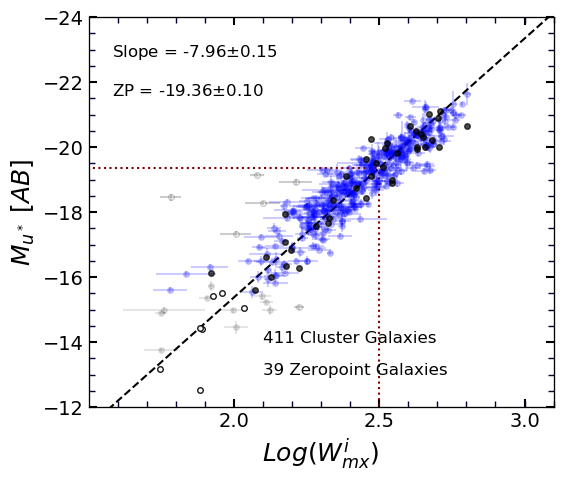

In [45]:
# magCorrection = -1*(0.89*(i_w1)+0.47)  ## right

magCorrection = -1*(0.50*(u_w1)-0.48)

# magCorrection = -1*(.10*(m21_u)-0.10)

# magCorrection = -1*(0.76*(u_i)-1.13)

###########################

# magCorrection = -1*(-0.13*(D_mu50_u)-0.21)
# magCorrection = -1*(0.17*(D_m21_u)-0.29)

# magCorrection = -1*(0.27*(D_u_i))
 
# magCorrection *= 0
 

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                            band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True, 
                                            OP_IR=True,
                                            magCorrection=magCorrection)

slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]


boolean = True
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        I_mag = myCluster['mag']-zp_+zp
        logWimx = myCluster['logWimx']
        pgc =  myCluster['pgc']
        I_mag_w = myCluster['mag_w']-zp_+zp
        logWimx_w = myCluster['logWimx_w']    


        indx = []
        indx_ = []    
        for i, id in enumerate(pgc):
            if not id in I_maglim:
                indx.append(i)
            else:
                indx_.append(i)             

        if boolean:
            logWimx_=logWimx[indx]
            mag_=I_mag[indx]
            logWimx_e_=myCluster['logWimx_e'][indx]
            boolean = False
        else:                    
            logWimx_=np.concatenate((logWimx_, logWimx[indx]))
            mag_=np.concatenate((mag_, I_mag[indx]))
            logWimx_e_=np.concatenate((logWimx_e_, myCluster['logWimx_e'][indx]))  


rms, RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, zp)


print band, len(logWimx_), '%.2f'%slope, '%.2f'%slope_e, '%.2f'%zp, '%.2f'%zp_e,'%.2f'%rms, '%.2f'%RMS

mag_ = zp_calibs['MAG']
logWimx_ = zp_calibs['logWimx']
mag_e = zp_calibs['mag_e']
logWimx_e = zp_calibs['logWimx_e']
pgc = zp_calibs['pgc']
indx = []
indx_ = []    
for i, id in enumerate(pgc):
    if not id in calib_maglim:
        indx.append(i)
    else:
        indx_.append(i)  
        
rms,RMS = rmsMaker(logWimx_[indx], mag_[indx], logWimx_e[indx], slope, zp)
print 'ZP calib', len(logWimx_[indx]), '%.2f'%rms, '%.2f'%RMS


In [46]:
d_lst = []
de_lst = []
keys = []
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        #print key, myCluster['slope'], myCluster['zp']-zp
        
        d_modulus = myCluster['zp']-zp
        d_modulus_e = myCluster['zp_e']
        d_lst.append(d_modulus)
        de_lst.append(d_modulus_e)
        keys.append(key)

print 

indx  = np.argsort(d_lst)

   
    
for i in indx:
    key = keys[i]
    myCluster = Clusters[key]
    
    pgc = myCluster['pgc']
    indx = []
    indx_ = []    
    for jj, id in enumerate(pgc):
        if not id in I_maglim:
            indx.append(jj)
        else:
            indx_.append(jj)      
    
    
    print myCluster['name']+ ' & u & $u^*-W1^*$ & '+'%d'%len(pgc[indx])+' & '+'%.2f'%d_lst[i]+ '$\pm$'+'%.2f'%de_lst[i][0]+' \\\\'
    


Virgo & u & $u^*-W1^*$ & 24 & 30.92$\pm$0.09 \\
Ursa Major & u & $u^*-W1^*$ & 37 & 31.31$\pm$0.07 \\
Pegasus & u & $u^*-W1^*$ & 24 & 33.33$\pm$0.12 \\
Abell 262 & u & $u^*-W1^*$ & 7 & 33.68$\pm$0.23 \\
NGC410 & u & $u^*-W1^*$ & 31 & 34.02$\pm$0.08 \\
NGC507 & u & $u^*-W1^*$ & 19 & 34.03$\pm$0.11 \\
Cancer & u & $u^*-W1^*$ & 17 & 34.18$\pm$0.11 \\
NGC80 & u & $u^*-W1^*$ & 13 & 34.57$\pm$0.09 \\
NGC70 & u & $u^*-W1^*$ & 11 & 34.60$\pm$0.12 \\
Abell 1367 & u & $u^*-W1^*$ & 62 & 34.75$\pm$0.06 \\
Coma & u & $u^*-W1^*$ & 75 & 34.76$\pm$0.06 \\
Abell 400 & u & $u^*-W1^*$ & 20 & 34.78$\pm$0.07 \\
NGC4065 & u & $u^*-W1^*$ & 12 & 35.07$\pm$0.10 \\
Abell 2634/66 & u & $u^*-W1^*$ & 26 & 35.33$\pm$0.07 \\
Abell 2151 (Hercules) & u & $u^*-W1^*$ & 33 & 35.93$\pm$0.07 \\
